In [3]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

#torch.use_deterministic_algorithms(True)

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Feb 25 2025

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

torchvision: 0.18.0
torch      : 2.3.0
matplotlib : 3.9.0
numpy      : 1.26.4

Watermark: 2.4.3



#### Dataset information
- There are 240 training images and 150 validation images divided equally between the two classes (bees and ants). 
- We download the dataset from this link - https://www.kaggle.com/ajayrana/hymenoptera-data and store it in the current working directory. 
- In order to download the dataset you will need to login to kaggle. If you do not already have a kaggle account, you will need to register.
- More information about the dataset can be found here: https://hymenoptera.elsiklab.missouri.edu/

In [5]:
INPUT_DIR = 'data/hymenoptera_data'
IMAGENET_MEAN = np.array([0.490, 0.449, 0.411])
IMAGENET_STD = np.array([0.231, 0.221, 0.230])
BATCH_SIZE = 4
# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])}

dataset = {k: datasets.ImageFolder(os.path.join(INPUT_DIR, k), data_transformers[k]) for k in ['train', 'val']}
dataloader = {k: torch.utils.data.DataLoader(dataset[k], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 
            for k in ['train', 'val']}
dataset_size = {x: len(dataset[x]) for x in ['train', 'val']}
dataset_classes = dataset['train'].classes
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE, type(DEVICE))

cuda:0 <class 'torch.device'>


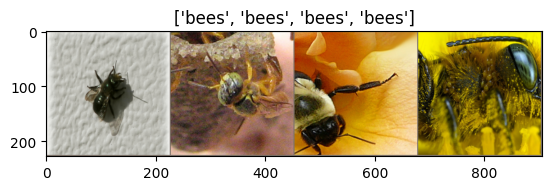

In [6]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dataloader['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[dataset_classes[c] for c in cls])

In [7]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 25
    ):
    r"""Training the model. Returns best model, dictionary of train and validation losses, dictionary of train and validation accuracies.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        sheduler (torch.nn.Module): Learning rate change policy
        epochs (int): Number of training iterations. Default: 25
    """
    
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')
    
    for epoch in progress:
        for phase in ['train', 'val']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))
            
            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
            
                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)
                
                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()
                
            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum.item() / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

In [8]:
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

In [9]:
model_finetune = models.alexnet(pretrained=True)
#for param in model_finetune.parameters():
#    param.requires_grad = False
model_finetune

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [11]:
# change the last layer from 1000 classes to 2 classes
for param in model_finetune.parameters():
    param.requires_grad = False
model_finetune.classifier[6] = nn.Linear(4096, len(dataset_classes))
model_finetune.to(DEVICE)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_finetune.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train (fine-tune) and validate the model
model_finetune, losses, accuracies = train_model(model_finetune, loss, optimizer, scheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.198883073516015e-09..0.9333333144187927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.198883073516015e-09..1.0000000066757202].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764704942703208..1.0000000066757202].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.198883073516015e-09..1.0000000066757202].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.198883073516015e-09..0.9999999620914459].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.198883073516015e-09..0.9999999747276307].
Clippi

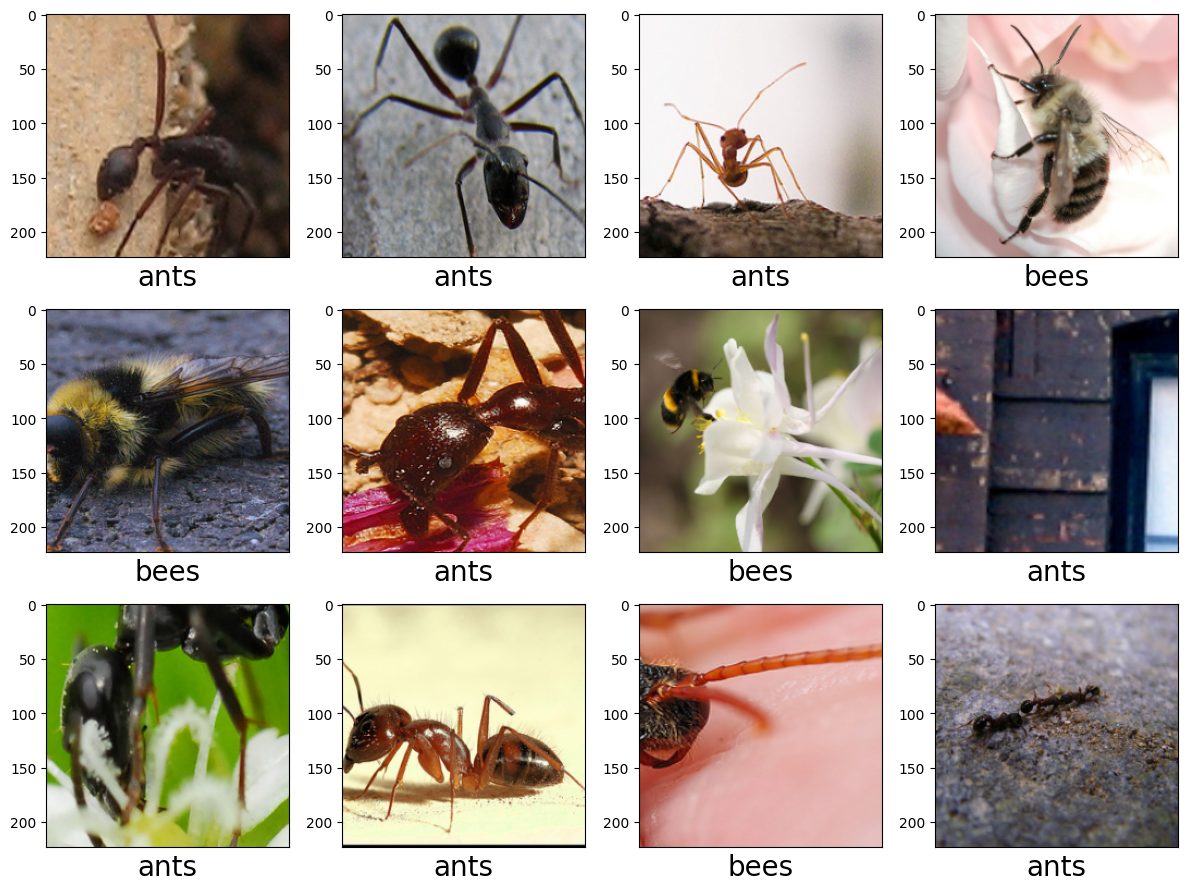

In [12]:
# show 12 images
images, classes = get_batches(dataloader['train'])
show_batches(images, classes)

In [13]:
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['val'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

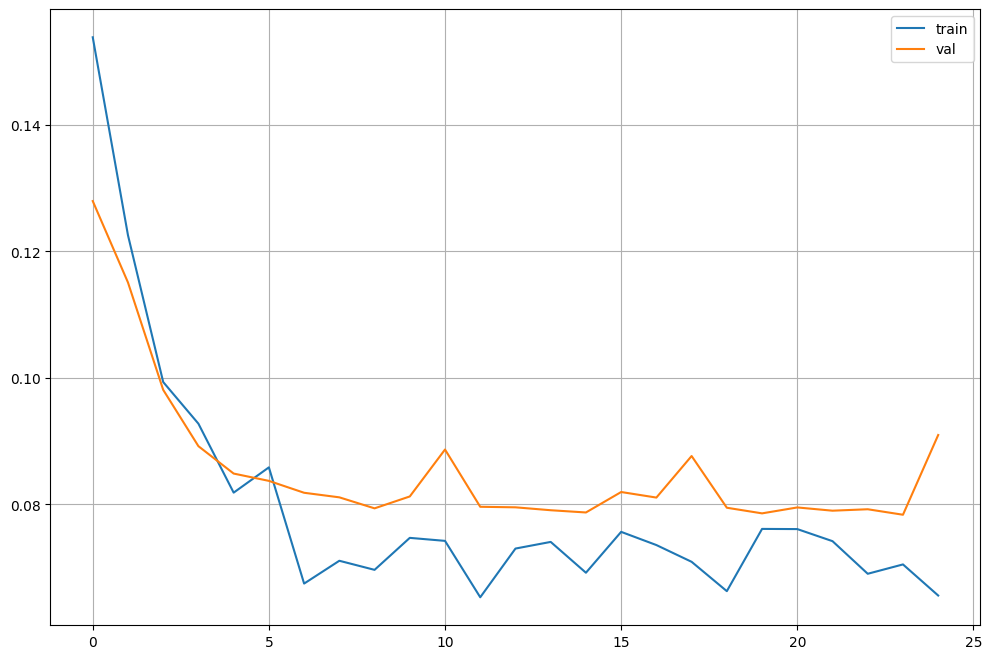

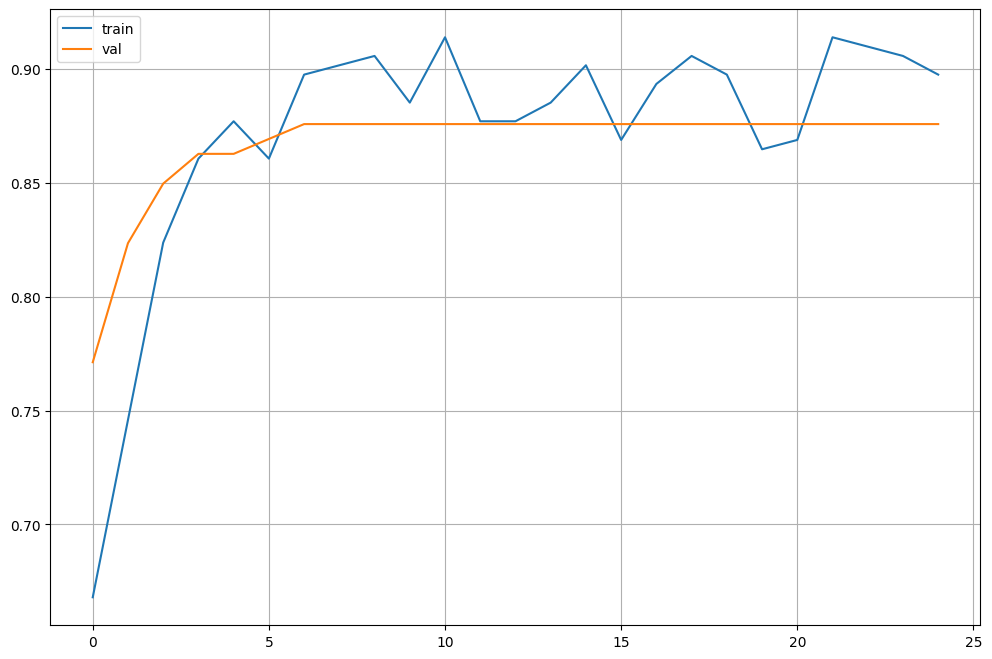

Best Validation Accuracy:  0.8758169934640523


In [14]:
show_metrics(losses)
show_metrics(accuracies)
print("Best Validation Accuracy: ", max(accuracies['val']))

### Finetune

In [15]:
model = torchvision.models.alexnet(pretrained=True)

In [16]:
layers_to_freeze = 6
for i, (name, param) in enumerate(model.features.named_parameters()):
    if i < layers_to_freeze:
        param.requires_grad = False
    print(f'{name:30}{param.requires_grad}')
model.classifier[6] = nn.Linear(4096, len(dataset_classes))
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
retrain_layers = list(model.features.parameters())[layers_to_freeze:] + list(model.classifier.parameters())
optimizer = torch.optim.Adam(retrain_layers, lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

0.weight                      False
0.bias                        False
3.weight                      False
3.bias                        False
6.weight                      False
6.bias                        False
8.weight                      True
8.bias                        True
10.weight                     True
10.bias                       True


Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

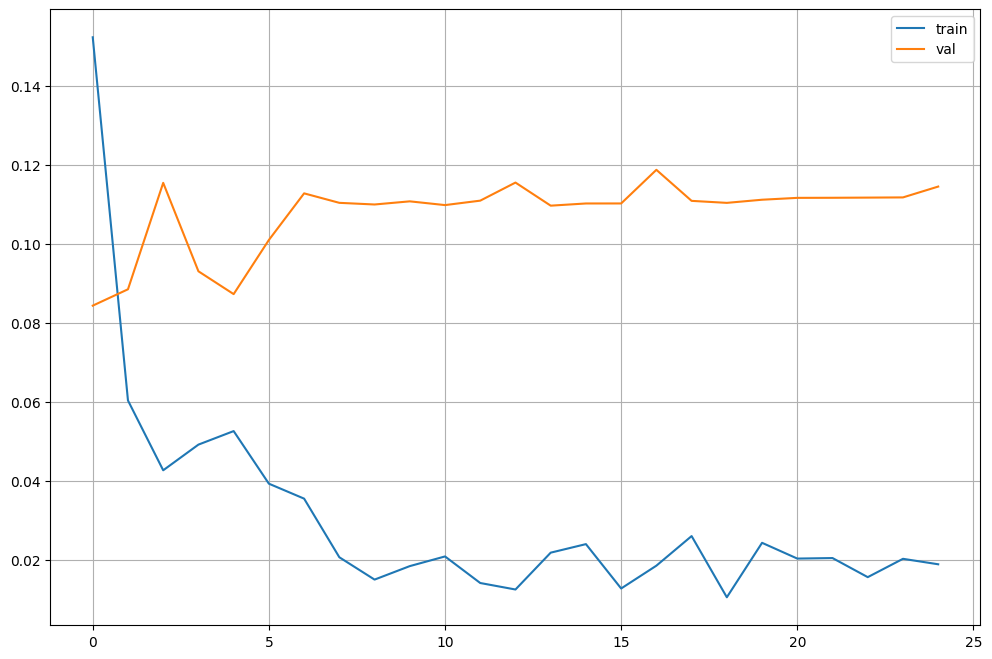

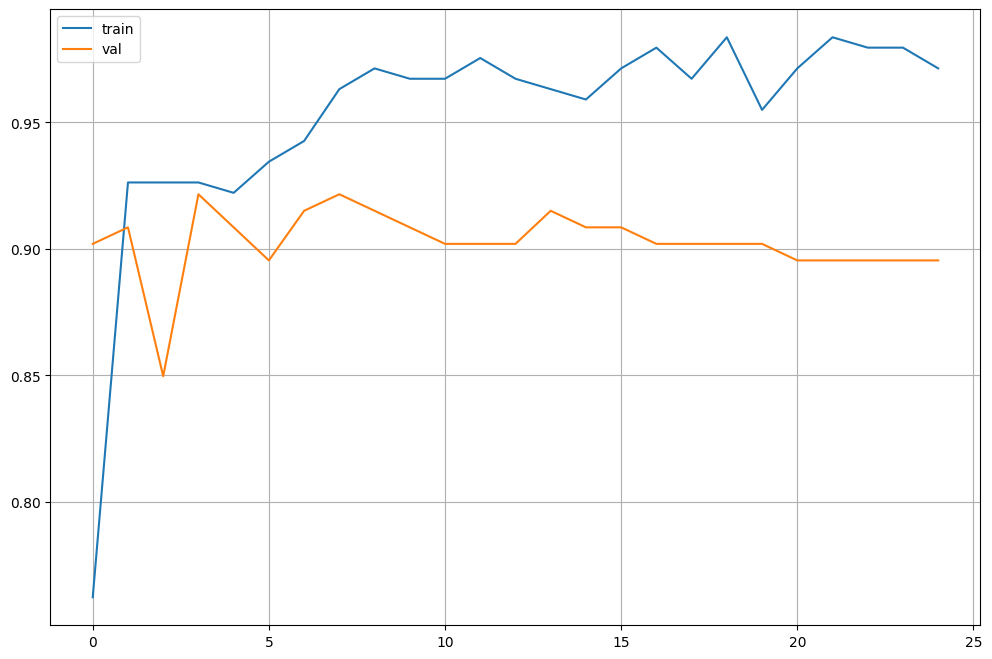

0.9215686274509803

In [17]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])

### Tune optimizer

In [18]:
model = torchvision.models.alexnet(pretrained=True)

In [19]:
model.classifier[6] = nn.Linear(4096, len(dataset_classes))
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer_params = [
    {'params': model.features.parameters(), 'lr': 1e-6},
    {'params': model.classifier.parameters(), 'lr': 1e-4},
]
optimizer = torch.optim.Adam(optimizer_params)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

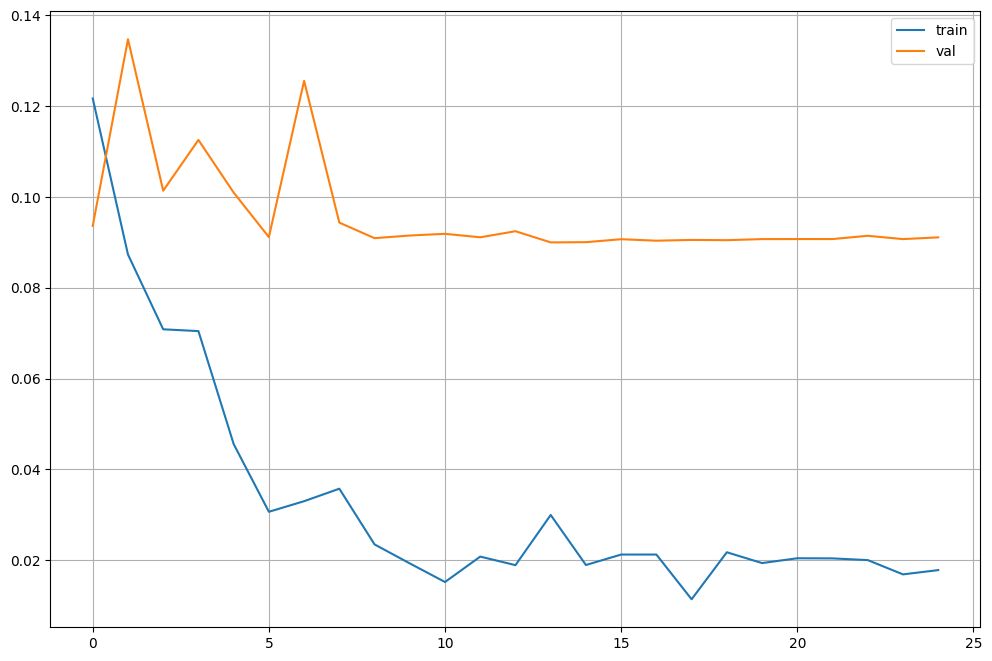

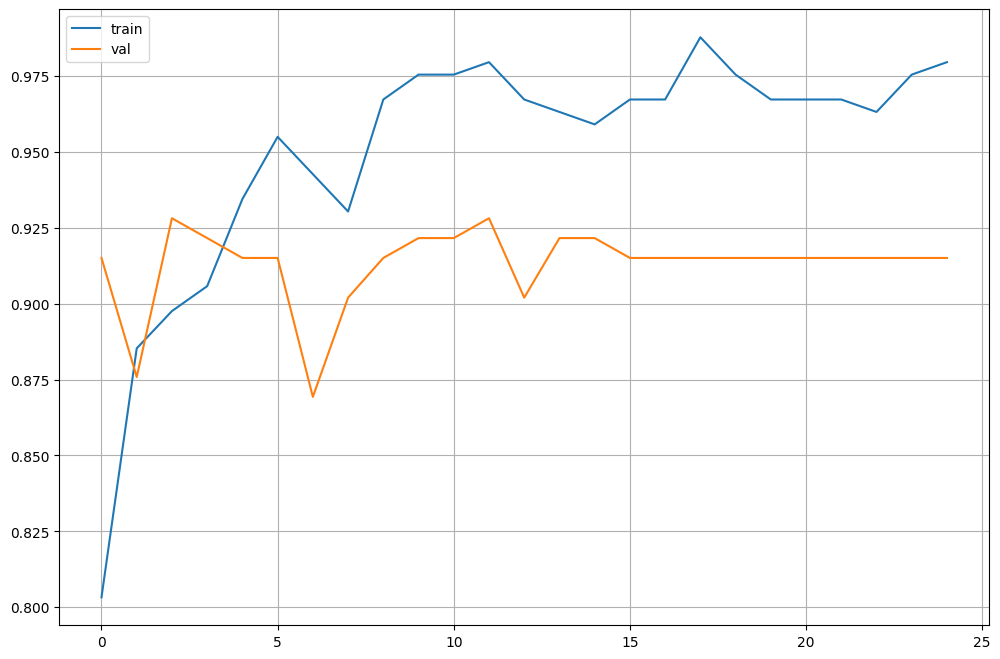

0.9281045751633987

In [20]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])